In [15]:
# -------------------------------------------------------- Imports --------------------------------------------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import random
from PIL import Image

In [16]:
print('asd')

asd


In [17]:
# -------------------------------------------------------- Global settings --------------------------------------------------------------
warnings.simplefilter("always")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently running on {device}".format())

Currently running on cuda


In [18]:
# Loading the data
%run '/notebooks/DataLoaders/DataLoaders.ipynb'

/tmp/ipykernel_223/2785347503.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='/notebooks/cnnimageretrieval-pytorch/data/test/pascalvoc/gnd_pascalvoc_700.pkl'>
  dataset = PascalVOCEasyDataset(image_dir=PASCALVOC_DATASET_FOLDERPATH,transform=content_transform)


In [19]:
%run '/notebooks/Autoencoders/Models/MAE-Transformer.ipynb'

In [20]:
# Hyperparameters
SAVE_PATH = '/notebooks/Checkpoints/masked-autoencoder-pascalvoc_700.torch'
NUM_EPOCHS = 200

In [21]:
model = MAETransformer(512, patch_size = 16, 
 num_input_channels = 3,
 encoder_embedding_dim = 768, depth = 12,num_heads = 12,
 decoder_embed_dim = 512, decoder_depth = 8, decoder_num_heads= 16,
 mlp_ratio = 4.0, qkv_bias = True,
 device=device)
model = model.to(device)

In [22]:
# Safer method as per https://discuss.pytorch.org/t/should-i-create-optimizer-after-sending-the-model-to-gpu/133418
optimiser = torch.optim.Adam(model.parameters(),lr=0.001,)

In [23]:
model = torch.load(SAVE_PATH)
model = model.to(device)

In [24]:
# pip install torchinfo
#from torchinfo import summary
#summary(model,(50,3,512,512))

In [25]:
def compute_score(model, validation_dataset, device):
    loss = 0
    for idx,batch_data in enumerate(validation_dataset):
        batch_data = batch_data.to(device)
        loss, pred, mask = model(batch_data)
        loss += loss.item()
        del batch_data
    
    return loss / len(validation_dataset)

In [26]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip(image* 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()
    return

In [27]:
def train_loop(model, optimiser, train_dataset, validation_dataset, NUM_EPOCHS, save_path):
    best_loss  = 100000
    validation_loss = None
    for epoch in range(NUM_EPOCHS):
        loss_sum = 0
        print("Running epoch {}.....".format(epoch+1))
        for idx, batch_data in enumerate(train_dataset):
                        
            optimiser.zero_grad()
            batch_data = batch_data.to(device)
            loss, pred, mask = model(batch_data)
            unpatched = model.unpatchify(pred)

            
            mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size**2 *3)  # (N, H*W, p*p*3)
            mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping

            im_masked = batch_data * (1 - mask)

            im_reconstituted = im_masked + unpatched * mask 
            
            #if(idx == 0):
            
            loss.backward()
            optimiser.step()
            temp_loss = loss.item()
            loss_sum += temp_loss
            
            
            if(idx == 0):
                selected_idx = random.randint(0, batch_data.shape[0] - 1 )
                show_image(batch_data[selected_idx].cpu().detach().permute(1,2,0),'Original')
                show_image(mask[selected_idx].cpu().detach().permute(1,2,0), 'Mask')
                show_image((batch_data[selected_idx] *  (1 - mask[selected_idx])).cpu().detach().permute(1,2,0), 'Masked Original')
                show_image((unpatched * mask)[selected_idx].cpu().detach().permute(1,2,0), 'Predicted')
                show_image(im_reconstituted[selected_idx,:,:,:].cpu().detach().permute(1,2,0),'Reconstituted')
            
            
            
            if((idx+1)%50 == 0):                
                print("Running batch {} / {}. Batch loss {}".format(idx+1, len(train_dataset),temp_loss))
                #selected_idx = random.randint(0, batch_data.shape[0] - 1 )
                #show_image(batch_data[selected_idx].cpu().detach().permute(1,2,0),'Original')
                #show_image(mask[selected_idx].cpu().detach().permute(1,2,0), 'Mask')
                #show_image((unpatched * mask)[selected_idx].cpu().detach().permute(1,2,0), 'Predicted')
                #show_image(im_reconstituted[selected_idx,:,:,:].cpu().detach().permute(1,2,0),'Reconstituted')
                
            del batch_data
            
                
        loss_avg = loss_sum / len(train_dataset)
        print("Running batch {} / {}".format(idx+1, len(train_dataset)))
        print("Epoch Loss: {}".format(loss_avg))
        if((epoch+1) %100 == 0):
            validation_loss = compute_score(model, validation_dataset,device )
            print("Validation loss : {}".format(validation_loss))
        
        if(loss_avg < best_loss):
            torch.save(model, save_path)
            best_loss = loss_avg


Running epoch 1.....


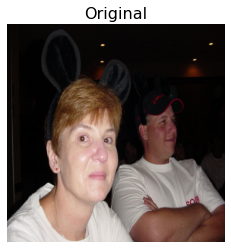

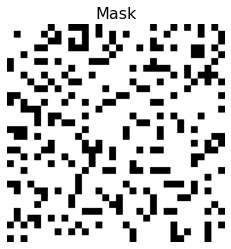

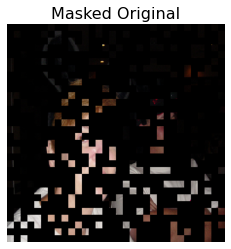

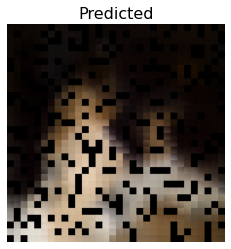

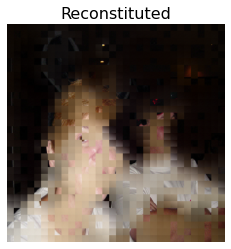

Running batch 50 / 462. Batch loss 0.020152507349848747
Running batch 100 / 462. Batch loss 0.022671258077025414
Running batch 150 / 462. Batch loss 0.021362721920013428
Running batch 200 / 462. Batch loss 0.02250847779214382
Running batch 250 / 462. Batch loss 0.02091701328754425
Running batch 300 / 462. Batch loss 0.023418547585606575
Running batch 350 / 462. Batch loss 0.019011247903108597
Running batch 400 / 462. Batch loss 0.019192354753613472
Running batch 450 / 462. Batch loss 0.021387433633208275
Running batch 462 / 462
Epoch Loss: 0.021312880958732846
Running epoch 2.....


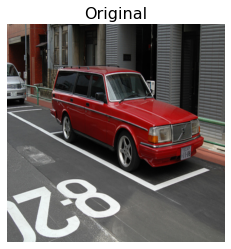

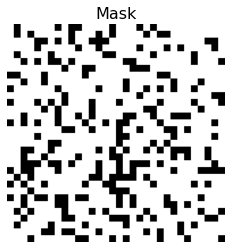

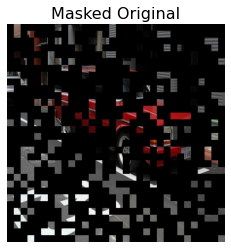

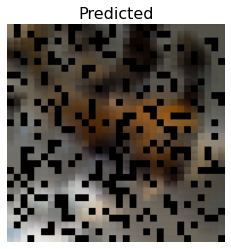

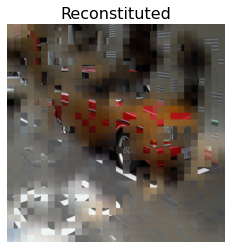

KeyboardInterrupt: 

In [29]:
train_loop(model, optimiser,
           train_dataloader, train_dataloader, NUM_EPOCHS, save_path = SAVE_PATH)

In [14]:
compute_score(model, test_dataloader,device)

ERROR! Session/line number was not unique in database. History logging moved to new session 3



KeyboardInterrupt

